Comparing the performance of fake review classification for a handufull of different classifiers while using the bag of word or TG-IDF text representation methods. 

In [29]:
#Imports

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import nltk
from nltk.corpus import stopwords
import string
from sklearn.model_selection import train_test_split, KFold
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

import warnings
import time

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score

In [64]:
#Seed used for all random operations in order to be able to replicate the experiment
seed = 3765

MODEL_NAMES = ["RandomForestClassifier", "AdaBoostClassifier", "KNearesNeighborsClassifier", "SVMClassifier", "MLPClassifier"]

In [31]:
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('stopwords')
nltk.download("punkt")

lemmatizer = nltk.WordNetLemmatizer()
bagOfWordsVectorizer = CountVectorizer()
tfidfVectorizer = TfidfVectorizer()

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\emiln\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\emiln\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\emiln\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\emiln\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [32]:
dataFrame = pd.read_csv('fake reviews dataset.csv', names=['category', 'rating', 'label', 'reviewText'])
#Drop the first row
dataFrame = dataFrame.iloc[1:]
dataFrame.shape

(40432, 4)

In [33]:
dataFrame.head()

,category,rating,label,reviewText
1,Home_and_Kitchen,5.0,CG,"Love this! Well made, sturdy, and very comfor..."
2,Home_and_Kitchen,5.0,CG,"love it, a great upgrade from the original. I..."
3,Home_and_Kitchen,5.0,CG,This pillow saved my back. I love the look and...
4,Home_and_Kitchen,1.0,CG,"Missing information on how to use it, but it i..."
5,Home_and_Kitchen,5.0,CG,Very nice set. Good quality. We have had the s...


In [34]:
print("Number of NaN values in each column")
dataFrame.isnull().sum()

Number of NaN values in each column


category      0
rating        0
label         0
reviewText    0
dtype: int64

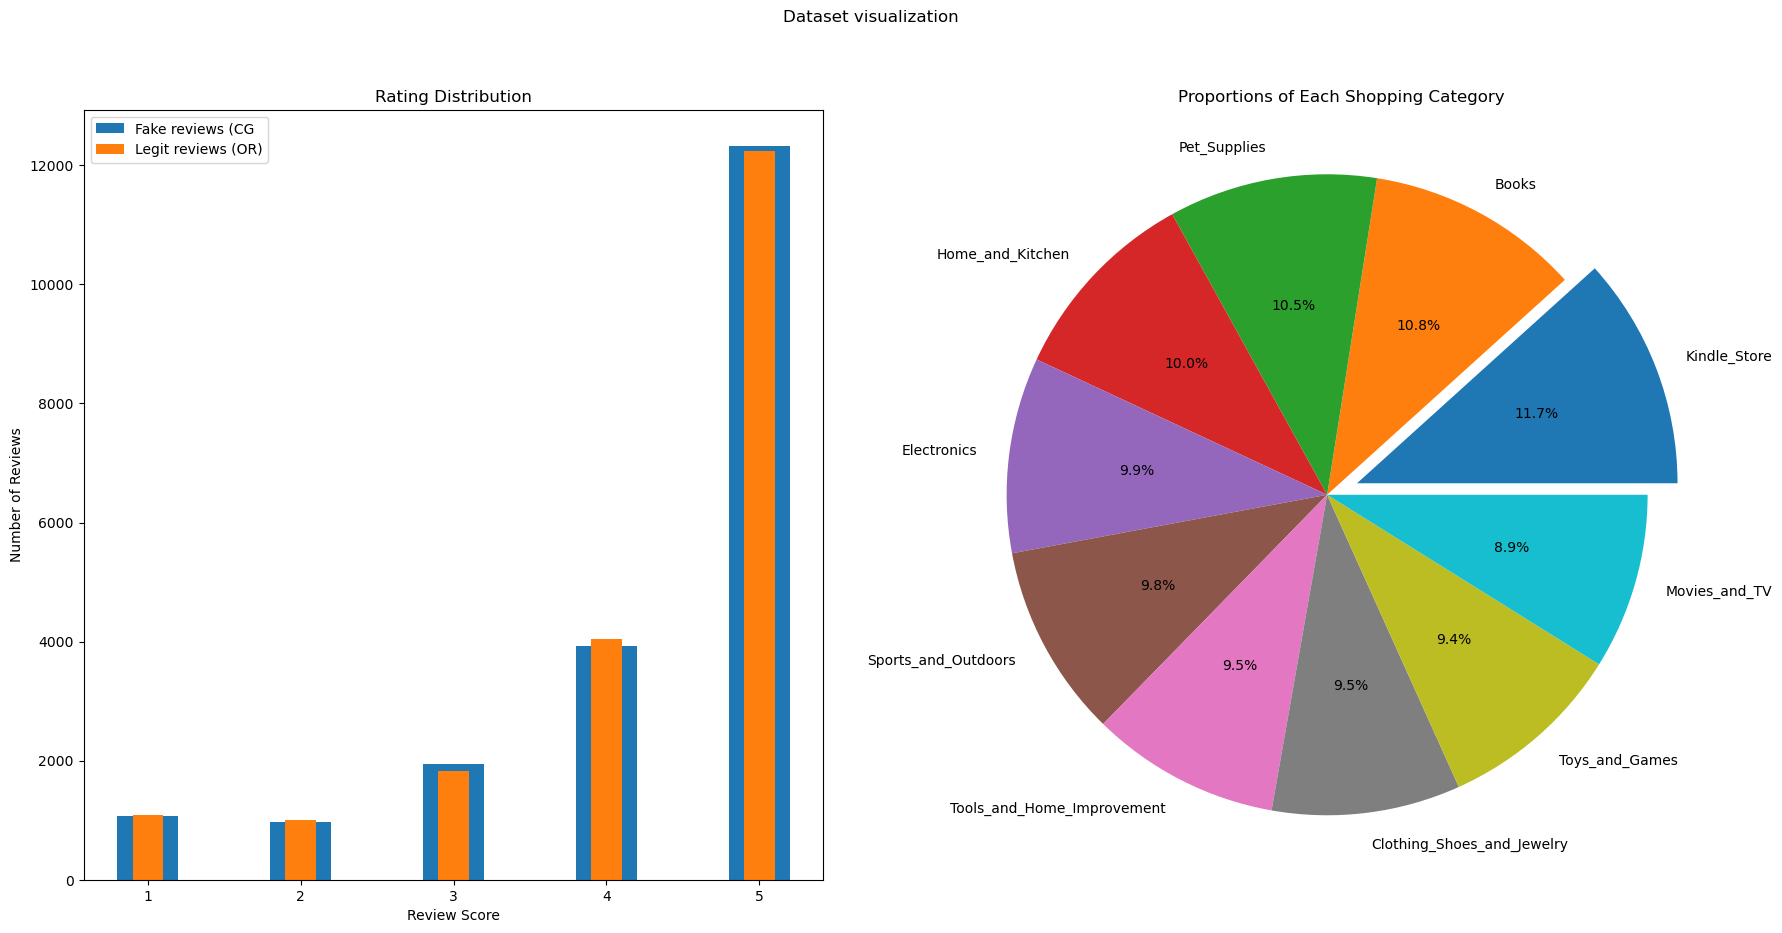

<Figure size 4000x2000 with 0 Axes>

In [67]:
fig, axs = plt.subplots(1, 2, figsize=(21, 10))
plt.figure(figsize=(40,20))
fig.suptitle("Dataset visualization")

labelsRating = dataFrame["rating"].value_counts().keys()
valuesRatingFakeReviews = dataFrame["rating"].loc[dataFrame["label"] == "CG"].value_counts().values
valuesRatingLegitReviews = dataFrame["rating"].loc[dataFrame["label"] == "OR"].value_counts().values
axs[0].set_title("Rating Distribution")
axs[0].set_xlabel("Review Score")
axs[0].set_ylabel("Number of Reviews")
axs[0].bar(labelsRating, valuesRatingFakeReviews, width=0.4, label="Fake reviews (CG")
axs[0].bar(labelsRating, valuesRatingLegitReviews, width=0.2, label="Legit reviews (OR)")
axs[0].legend()

labelsCategory = dataFrame["category"].value_counts().keys()
valuesCategory = dataFrame["category"].value_counts().values
explodeArr = [0.1,0,0,0,0,0,0,0,0,0] 
axs[1].set_title("Proportions of Each Shopping Category")
axs[1].pie(valuesCategory, labels=labelsCategory, explode=explodeArr, autopct='%1.1f%%', shadow=False)
axs[1].axis("equal")

plt.show()

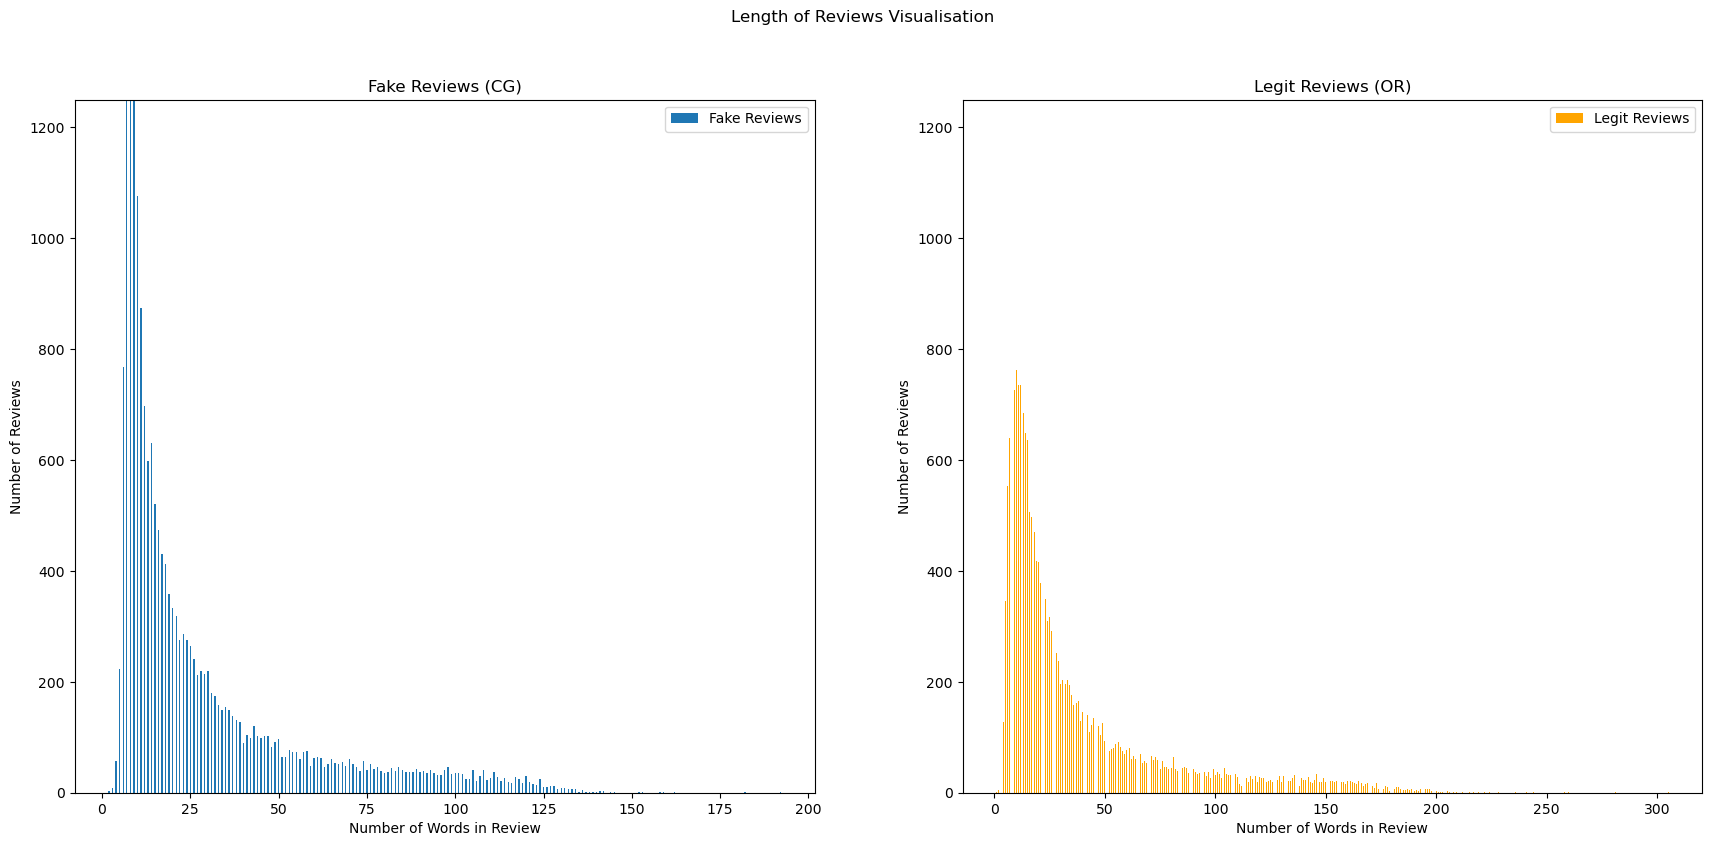

<Figure size 4000x2000 with 0 Axes>

In [69]:
fig, axs = plt.subplots(1, 2, figsize=(21, 9))
plt.figure(figsize=(40,20))
fig.suptitle("Length of Reviews Visualisation")

valuesReviewTxtLenCG = dataFrame["reviewText"].loc[dataFrame["label"] == "CG"].apply(lambda x: len(x.split())).value_counts()
labelsReviewTxtLenCG = valuesReviewTxtLenCG.keys()
axs[0].bar(labelsReviewTxtLenCG,valuesReviewTxtLenCG, width=0.4, label="Fake Reviews")
axs[0].set_ylim(0,1250)
axs[0].set_ylabel("Number of Reviews")
axs[0].set_xlabel("Number of Words in Review")
axs[0].set_title("Fake Reviews (CG)")
axs[0].legend()

valuesReviewTxtLenOR = dataFrame["reviewText"].loc[dataFrame["label"] == "OR"].apply(lambda x: len(x.split())).value_counts()
labelsReviewTxtLenOR = valuesReviewTxtLenOR.keys()
axs[1].bar(labelsReviewTxtLenOR,valuesReviewTxtLenOR,width=0.4, color="orange", label="Legit Reviews")
axs[1].set_ylim(0,1250)
axs[1].set_ylabel("Number of Reviews")
axs[1].set_xlabel("Number of Words in Review")
axs[1].set_title("Legit Reviews (OR)")
axs[1].legend()

plt.show()

Comments: Based on the above figures, one can clearly see that a lot of the fake reviews are under 25 words. Wheras the 

Preprocess data

In [37]:
def cleanText(text):
    text = text.lower()
    text = ' '.join([word for word in nltk.word_tokenize(text) if word not in stopwords.words('english') and not word.isdigit() and word not in string.punctuation])
    text = ' '.join([lemmatizer.lemmatize(word) for word in text.split()])
    return text

In [38]:
dataFrame["reviewText"].head()

1    Love this!  Well made, sturdy, and very comfor...
2    love it, a great upgrade from the original.  I...
3    This pillow saved my back. I love the look and...
4    Missing information on how to use it, but it i...
5    Very nice set. Good quality. We have had the s...
Name: reviewText, dtype: object

In [39]:
dataFrame["reviewText"].head().apply(cleanText)

1       love well made sturdy comfortable love pretty
2    love great upgrade original 've mine couple year
3             pillow saved back love look feel pillow
4         missing information use great product price
5                 nice set good quality set two month
Name: reviewText, dtype: object

In [40]:
dataFrame["type"] = np.where(dataFrame["label"] == "CG", 1, 0)
dataFrame["reviewText"] = dataFrame["reviewText"].apply(cleanText)
dataFrame.to_csv('preprocessed_fake_reviews_dataset.csv')

KeyboardInterrupt: 

Create testing data

In [ ]:
X = dataFrame['reviewText']
Y = dataFrame['label']

X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size=0.2, train_size=0.8, random_state=seed, shuffle=True)

Bag of word

In [ ]:
X_train.shape

(32345,)

In [44]:
dataFrame = pd.read_csv('preprocessed_fake_reviews_dataset.csv')

#Drop all NaN values
dataFrame = dataFrame.dropna()

X = dataFrame['reviewText']
Y = dataFrame['label']

In [45]:
trainData, testData, trainLabels, testLabels = train_test_split(X, Y, test_size=0.2, train_size=0.8, random_state=seed, shuffle=True)

In [46]:
testData.shape

(8087,)

In [ ]:
trainData.shape

In [47]:
validationData, trainData, validationLabels, trainLabels = train_test_split(trainData, trainLabels, train_size=0.1, test_size=0.9, shuffle=True)

In [48]:
validationData.shape

(3234,)

In [49]:
trainData.shape

(29110,)

In [50]:
classifiersBagOfWords = {}
classifiersBagOfWords.update({"RandomForestClassifier": RandomForestClassifier()})
classifiersBagOfWords.update({"AdaBoostClassifier": AdaBoostClassifier()})
classifiersBagOfWords.update({"KNeighborsClassifier": KNeighborsClassifier()})
classifiersBagOfWords.update({"SVMClassifier": SVC()})
classifiersBagOfWords.update({"MLPClassifier": MLPClassifier()})

classifiersTFIDF = {}
classifiersTFIDF.update({"RandomForestClassifier": RandomForestClassifier()})
classifiersTFIDF.update({"AdaBoostClassifier": AdaBoostClassifier()})
classifiersTFIDF.update({"KNeighborsClassifier": KNeighborsClassifier()})
classifiersTFIDF.update({"SVMClassifier": SVC()})
classifiersTFIDF.update({"MLPClassifier": MLPClassifier()})

In [51]:
#Hyperparameters to optimize for each model
hyperParamLst = [
    {   #RandomForest
        'clf__n_estimators': [8,7,6,5,4,3,2,1],
        'clf__max_depth': [2,4,6,8,10,12,14,16]
    },


    {   #AdaBoost
        'clf__n_estimators': [10,20,30,40,50,60,70,75,80],
        'clf__learning_rate': [0,1,3,6,12,15,18,21,25]
    },

    {   #KNN
        'clf__n_neighbors': [1,3,5,7,10,12,13,14],
        'clf__p': [1,2]
    },

    {   #SVM
        'clf__kernel': ["linear", "poly", "rbf"],
        'clf__C': [0.1,2,3,5,7,10,12,14,16]
    },

    {   #MLP
        'clf__hidden_layer_sizes': [(4,2),(6,3),(6,4),(8,4),(10,5),(15,5),(15,10),(20,10),(30,15)],
        'clf__learning_rate': ["constant", "invscaling", "adaptive"]
    }
]

Optimize the hyperparameters for every model by utilizing 3-fold on the validation set

In [52]:
#Supress the warnings coming from sklearn
warnings.simplefilter("ignore")

optimalParamLstBagOfWords = []
optimalParamLstTFIDF = []
for keyClassifier, i in zip(classifiersBagOfWords, range(0, len(hyperParamLst))):
    pipelineBOW = Pipeline([("bagOfWords", bagOfWordsVectorizer), ("clf", classifiersBagOfWords[keyClassifier])])
    pipelineTFIDF = Pipeline([("tfidf", tfidfVectorizer), ("clf", classifiersTFIDF[keyClassifier])])

    gridSearchBOW = GridSearchCV(pipelineBOW, hyperParamLst[i], cv=3, scoring="accuracy")
    gridSearchBOW.fit(validationData, validationLabels)
    
    gridSearchTFIDF = GridSearchCV(pipelineTFIDF, hyperParamLst[i], cv=3, scoring="accuracy")
    gridSearchTFIDF.fit(validationData, validationLabels)

    print("Current Classifier:", keyClassifier)
    print("The optimal hyperparameters with 'bag of word' as vector representation: " + str(gridSearchBOW.best_params_) + ". This setup got the following accuracy: " + str(gridSearchBOW.best_score_ * 100) + "%")
    print("The optimal hyperparameters with 'TF-IDF' as vector representation: " + str(gridSearchTFIDF.best_params_) + ". This setup got the following accuracy: " + str(gridSearchTFIDF.best_score_ * 100) + "%")
    print("\n")

    optimalParamLstBagOfWords.append(gridSearchBOW.best_params_)
    optimalParamLstTFIDF.append(gridSearchTFIDF.best_params_)
    

Current Classifier: RandomForestClassifier
The optimal hyperparameters with 'bag of word' as vector representation: {'clf__max_depth': 16, 'clf__n_estimators': 8}. This setup got the following accuracy: 68.18181818181817%
The optimal hyperparameters with 'TF-IDF' as vector representation: {'clf__max_depth': 14, 'clf__n_estimators': 7}. This setup got the following accuracy: 70.65553494124921%


Current Classifier: AdaBoostClassifier
The optimal hyperparameters with 'bag of word' as vector representation: {'clf__learning_rate': 1, 'clf__n_estimators': 75}. This setup got the following accuracy: 72.94372294372295%
The optimal hyperparameters with 'TF-IDF' as vector representation: {'clf__learning_rate': 1, 'clf__n_estimators': 70}. This setup got the following accuracy: 75.72665429808288%


Current Classifier: KNeighborsClassifier
The optimal hyperparameters with 'bag of word' as vector representation: {'clf__n_neighbors': 7, 'clf__p': 1}. This setup got the following accuracy: 61.564625

Train and test the different classifiers with the training and test data

In [54]:
dfModelsResult = pd.DataFrame(columns=["Classifier", "Vector Representation", "Training Time (minutes)", "Accuracy (%)", "f1 score"])

resultLstBOW = []
resultLstTFIDF = []
for keyClassifier, i in zip(classifiersBagOfWords, range(0, len(optimalParamLstBagOfWords))):
    pipelineBOW = Pipeline([("bagOfWords", bagOfWordsVectorizer), ("clf", classifiersBagOfWords[keyClassifier])])
    pipelineBOW.set_params(**optimalParamLstBagOfWords[i])
    startTrainingTime = time.time()
    pipelineBOW.fit(trainData,trainLabels)
    stopTrainingTime = time.time()
    predictedLabels = pipelineBOW.predict(testData)

    row = {'Classifier': keyClassifier,
        'Vector Representation': "Bag of Words",
        "Training Time (minutes)": format(round((stopTrainingTime-startTrainingTime)/60,2)),
        "Accuracy (%)": np.mean(predictedLabels==testLabels)*100,
        "f1 score": f1_score(testLabels, predictedLabels, average="macro")
    }

    dfModelsResult = dfModelsResult.append(row, ignore_index=True)
    resultLstBOW.append(predictedLabels)

    pipelineTFIDF = Pipeline([("tfidf", tfidfVectorizer), ("clf", classifiersTFIDF[keyClassifier])])
    pipelineTFIDF.set_params(**optimalParamLstTFIDF[i])
    startTrainingTime = time.time()
    pipelineTFIDF.fit(trainData, trainLabels)
    stopTrainingTime = time.time()
    predictedLabels = pipelineTFIDF.predict(testData)

    row = {'Classifier': keyClassifier,
        'Vector Representation': "TF-IDF",
        "Training Time (minutes)": format(round((stopTrainingTime-startTrainingTime)/60,2)),
        "Accuracy (%)": np.mean(predictedLabels==testLabels)*100,
        "f1 score": f1_score(testLabels, predictedLabels, average="macro")
    }

    dfModelsResult = dfModelsResult.append(row, ignore_index=True)
    resultLstTFIDF.append(predictedLabels)


<bound method Pipeline.get_params of Pipeline(steps=[('bagOfWords', CountVectorizer()),
                ('clf', RandomForestClassifier(max_depth=16, n_estimators=8))])>
<bound method Pipeline.get_params of Pipeline(steps=[('tfidf', TfidfVectorizer()),
                ('clf', RandomForestClassifier(max_depth=14, n_estimators=7))])>


<bound method Pipeline.get_params of Pipeline(steps=[('bagOfWords', CountVectorizer()),
                ('clf', AdaBoostClassifier(learning_rate=1, n_estimators=75))])>
<bound method Pipeline.get_params of Pipeline(steps=[('tfidf', TfidfVectorizer()),
                ('clf', AdaBoostClassifier(learning_rate=1, n_estimators=70))])>


<bound method Pipeline.get_params of Pipeline(steps=[('bagOfWords', CountVectorizer()),
                ('clf', KNeighborsClassifier(n_neighbors=7, p=1))])>
<bound method Pipeline.get_params of Pipeline(steps=[('tfidf', TfidfVectorizer()),
                ('clf', KNeighborsClassifier(n_neighbors=3))])>


<bound method Pipeline.g

In [55]:
dfModelsResult

,Classifier,Vector Representation,Training Time (minutes),Accuracy (%),f1 score
0,RandomForestClassifier,Bag of Words,0.02,71.472734,0.710262
1,RandomForestClassifier,TF-IDF,0.02,70.965747,0.709182
2,AdaBoostClassifier,Bag of Words,0.09,76.245827,0.762012
3,AdaBoostClassifier,TF-IDF,0.15,78.323235,0.782663
4,KNeighborsClassifier,Bag of Words,0.01,62.285149,0.608794
5,KNeighborsClassifier,TF-IDF,0.01,62.705577,0.586132
6,SVMClassifier,Bag of Words,2.37,86.323729,0.863237
7,SVMClassifier,TF-IDF,8.14,89.229628,0.892260
8,MLPClassifier,Bag of Words,3.1,83.492024,0.834752
9,MLPClassifier,TF-IDF,5.96,82.576975,0.825603


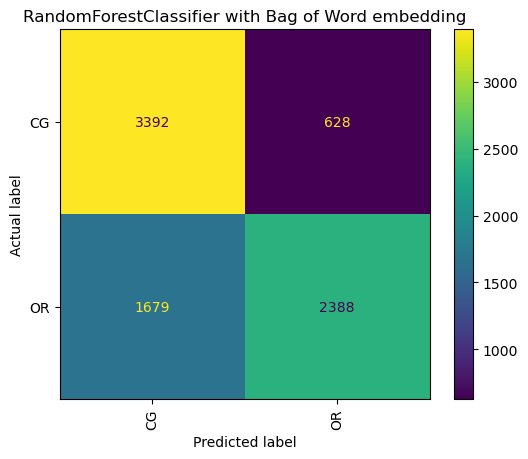

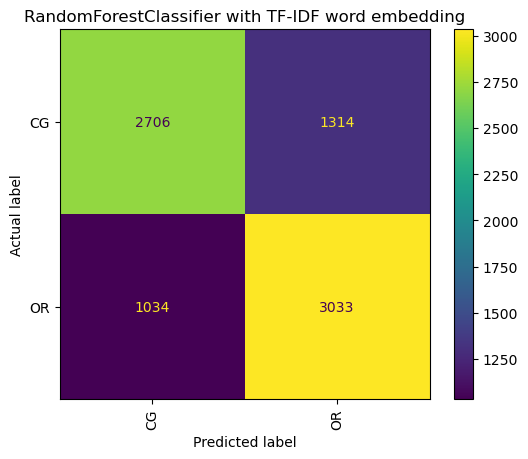

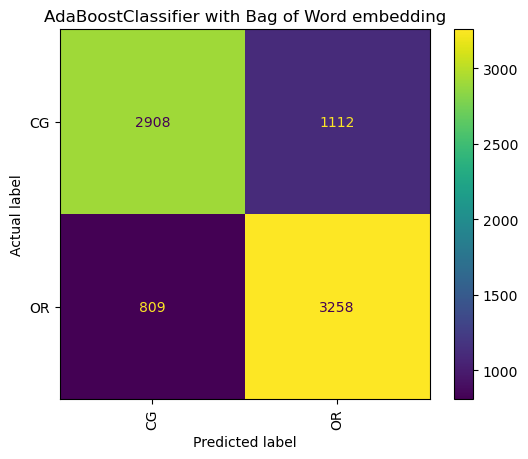

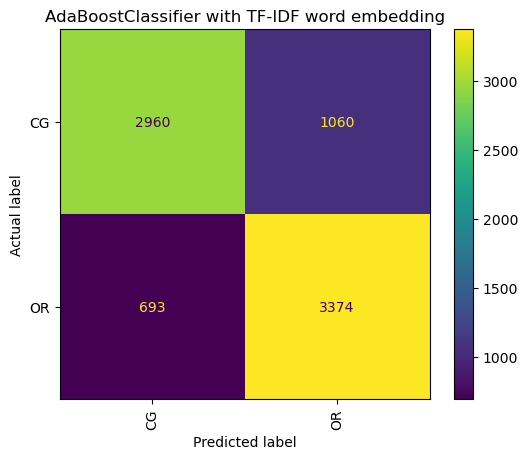

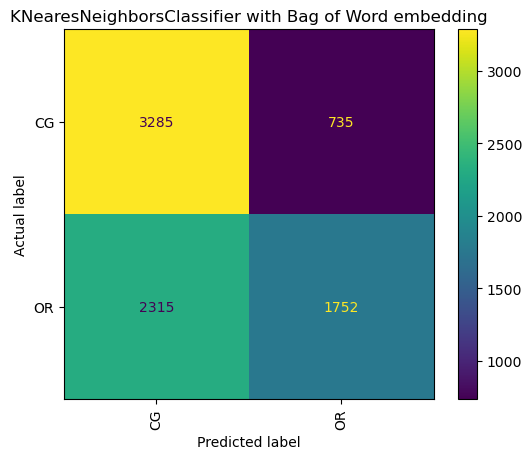

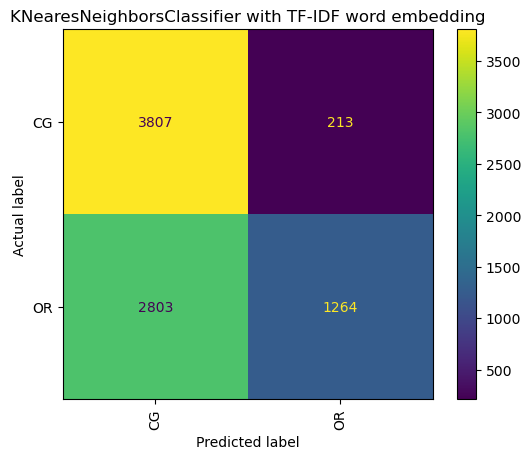

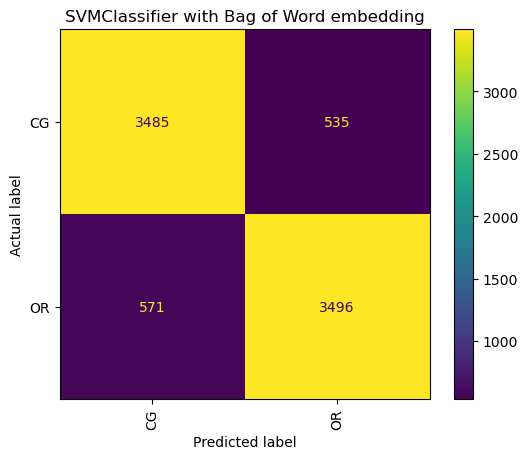

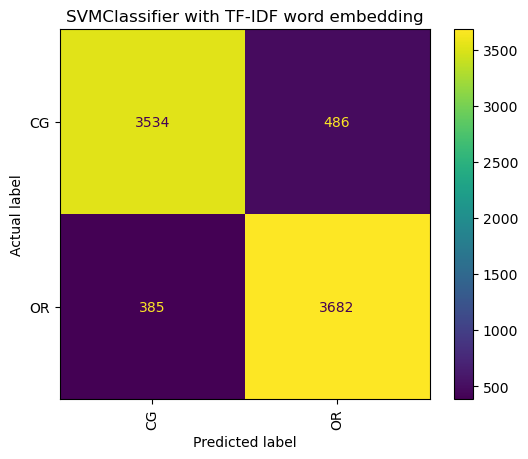

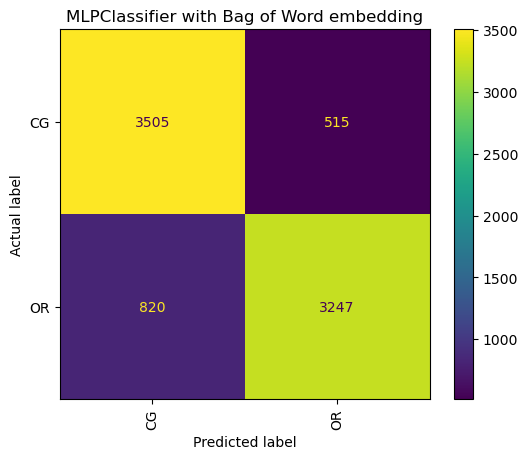

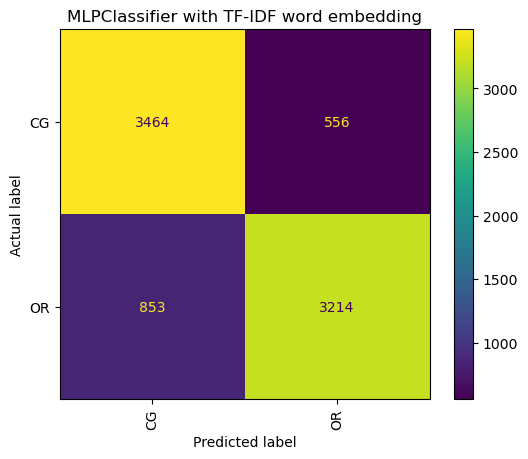

In [72]:
#Print the confusion matrices
for i in range(0, len(resultLstTFIDF)):
    ConfusionMatrixDisplay.from_predictions(testLabels, resultLstBOW[i], xticks_rotation="vertical")
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.title(str(MODEL_NAMES[i]) +" with Bag of Word embedding")
    plt.show()

    ConfusionMatrixDisplay.from_predictions(testLabels, resultLstTFIDF[i], xticks_rotation="vertical")
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.title(str(MODEL_NAMES[i]) +" with TF-IDF word embedding")
    plt.show()
